In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns

from pandas_profiling import ProfileReport

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor

from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [4]:
#my dataframe is quite large, starting at 150 columns and over 100,000 rows. 
#I will do some cleaning and feature engineering, but first I need to see all my columns
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [6]:
df_i = pd.read_csv('/Users/nicholashagemann/Lambda/loan_data.csv')
df_i.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,109889419.0,NaN,20000.0,20000.0,20000.0,36 months,9.44%,640.10,B,B1,IT Support,10+ years,MORTGAGE,99500.0,Source Verified,May-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,296xx,SC,17.19,0.0,Feb-2005,690.0,694.0,0.0,NaN,NaN,15.0,0.0,12835.0,41%,28.0,w,0.0,0.0,21657.670000,21657.67,20000.0,1657.67,0.0,0.0,0.0,Jun-2018,1002.69,NaN,Jul-2018,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,1185.0,159516.0,2.0,3.0,0.0,2.0,16.0,59354.0,70.0,2.0,2.0,4810.0,57.0,...,2.0,0.0,1.0,4.0,10634.0,15465.0,45.4,0.0,0.0,147.0,115.0,3.0,3.0,4.0,3.0,NaN,7.0,NaN,0.0,4.0,4.0,7.0,9.0,8.0,11.0,16.0,4.0,15.0,0.0,0.0,0.0,2.0,100.0,28.6,0.0,0.0,206029.0,72189.0,28300.0,84078.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,68579794.0,NaN,21600.0,21600.0,21600.0,36 months,9.80%,694.95,B,B3,Engineer Tech,10+ years,MORTGAGE,79000.0,Verified,Jan-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,219xx,MD,18.94,1.0,Jun-1995,680.0,684.0,0.0,12.0,NaN,13.0,0.0,17498.0,88.4%,16.0,w,0.0,0.0,24983.207947,24983.21,21600.0,3383.21,0.0,0.0,0.0,Nov-2018,8.94,NaN,May-2019,709.0,705.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,291267.0,0.0,2.0,2.0,2.0,7.0,33987.0,88.0,0.0,0.0,4746.0,88.0,...,0.0,0.0,0.0,2.0,22405.0,897.0,91.1,0.0,0.0,101.0,247.0,27.0,7.0,4.0,27.0,12.0,NaN,12.0,0.0,3.0,7.0,4.0,4.0,4.0,8.0,8.0,7.0,13.0,0.0,0.0,0.0,2.0,93.7,75.0,0.0,0.0,337728.0,51485.0,10100.0,38591.0,NaN,NaN,NaN,NaN

In [9]:
#in my wrangle function, I shall begin cleaning my data by identifying percentage of NaN
    #values for each column
for col in df_i.columns:
    print(f'NaN % is {round(df_i[col].isna().sum()/len(df)*100, 1)} for {col}.')

NaN % is 0.0 for Unnamed: 0.
NaN % is 0.0 for id.
NaN % is 100.0 for member_id.
NaN % is 0.0 for loan_amnt.
NaN % is 0.0 for funded_amnt.
NaN % is 0.0 for funded_amnt_inv.
NaN % is 0.0 for term.
NaN % is 0.0 for int_rate.
NaN % is 0.0 for installment.
NaN % is 0.0 for grade.
NaN % is 0.0 for sub_grade.
NaN % is 6.5 for emp_title.
NaN % is 6.0 for emp_length.
NaN % is 0.0 for home_ownership.
NaN % is 0.0 for annual_inc.
NaN % is 0.0 for verification_status.
NaN % is 0.0 for issue_d.
NaN % is 0.0 for loan_status.
NaN % is 0.0 for pymnt_plan.
NaN % is 0.0 for url.
NaN % is 91.2 for desc.
NaN % is 0.0 for purpose.
NaN % is 1.3 for title.
NaN % is 0.0 for zip_code.
NaN % is 0.0 for addr_state.
NaN % is 0.0 for dti.
NaN % is 0.0 for delinq_2yrs.
NaN % is 0.0 for earliest_cr_line.
NaN % is 0.0 for fico_range_low.
NaN % is 0.0 for fico_range_high.
NaN % is 0.0 for inq_last_6mths.
NaN % is 50.8 for mths_since_last_delinq.
NaN % is 83.1 for mths_since_last_record.
NaN % is 0.0 for open_acc.
NaN 

In [10]:
#each row in the data is a specific loan that was issued by a bank
#I choose the issue date of the loan to be the index
df = pd.read_csv('/Users/nicholashagemann/Lambda/loan_data.csv', 
                 parse_dates = ['issue_d', 'earliest_cr_line'], 
                 index_col = 'issue_d').sort_values('issue_d')

#we will need to wrangle this data quite a bit before it's suitable for predicting interest rate
def wrangle(df):
    #Begin Data Cleaning
    
    #first I get rid of all columns with more than 20% NaN values
    #note that the necessary columns will be dropped at the same time at the end of wrangle()
    nan_cols = []
    for col in df.columns:
        if df[col].isna().sum()/len(df) > 0.2:
            nan_cols.append(col)
            
    #each of the following columns had data that was only available after the loan had been approved
    #we want to predict the interest rate for a loan before the bank decides to approve the loan
    #thus, these columns contain leakage and should be dropped
    leaky_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                  'total_rec_int', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
                  'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med',
                  'funded_amnt', 'funded_amnt_inv', 'debt_settlement_flag']
    
    #the following columns did not contain any useful data or were duplicates of other columns
    cols_to_drop = ['title', 'zip_code', 'addr_state', 'fico_range_low', 
                    'Unnamed: 0', 'emp_title', 'url', 'id', 'last_credit_pull_d',
                    'earliest_cr_line']
    for col in df.columns:
        if df[col].nunique() == 1:
            cols_to_drop.append(col)
        
    #Begin Feature Engineering
    
    #first I create a feature which identifies how old the borrower's credit is
    df['credit_age'] = df.index - df['earliest_cr_line']
    df['credit_age'].astype('timedelta64[D]').astype(int)
    df['credit_age'] = df['credit_age'].dt.days.astype(int)
    
    #we want our interest rate to be a float, not a string
    #do the same for the amount of credit the borrower is using
    df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)
    df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)
    
    #we can represent the grade of the loan numerically
    #this column is leaky, and so I will drop it later
    #I keep it for now because it will have use in other analyses
    #and because it made my initial analysis more interesting
    df.loc[df['grade'] == 'A', 'grade'] = 4
    df.loc[df['grade'] == 'B', 'grade'] = 3
    df.loc[df['grade'] == 'C', 'grade'] = 2
    df.loc[df['grade'] == 'D', 'grade'] = 1
    df['grade'] = df['grade'].astype(int)
    
    #we want to represent length of the loan as an integer
    df.loc[df['term'] == ' 36 months', 'term'] = 36
    df.loc[df['term'] == ' 60 months', 'term'] = 60
    df['term'] = df['term'].astype(int)
    
    #we want to represent employment length as an integer
    df.loc[df['emp_length'] == '< 1 year', 'emp_length'] = 0
    df['emp_length'] = df['emp_length'].str.replace(' ', '').str.replace('year', '').str.replace('s', '').str.replace('+', '')
    df['emp_length'] = pd.to_numeric(df['emp_length'], downcast = 'integer', errors = 'ignore')
    
    #we want to represent whether or not the loan was paid off as an integer
    #for the interest rate analysis, we will drop this column
    #I do not drop it above because it will prove useful in other analyses
    df.loc[df['loan_status'] == 'Fully Paid', 'loan_status'] = 0
    df.loc[df['loan_status'] == 'Charged Off', 'loan_status'] = 1
    df['loan_status'] = df['loan_status'].astype(int)
    
    #we want to represent whether the application was individual or joint as binary
    df.loc[df['application_type'] == 'Individual', 'application_type'] = 1
    df.loc[df['application_type'] == 'Joint App', 'application_type'] = 0
    df['application_type'] = df['application_type'].astype(int)
    
    #we can represent intiial list status as binary
    #another leaky feature which we will remove later for the interest rate analysis,
    #but will be useful for other analyses
    df.loc[df['initial_list_status'] == 'w', 'initial_list_status'] = 1
    df.loc[df['initial_list_status'] == 'f', 'initial_list_status'] = 0
    df['initial_list_status'] = df['initial_list_status'].astype(int)
    
    #drop columns from the data cleaning
    df.drop(columns = nan_cols + leaky_cols + cols_to_drop, inplace = True)

    return df

df = wrangle(df)

In [11]:
#we can also convert the sub grade of the loan into an integer
#again, in our final analysis this column will be dropped but it will nevertheless
#be an interesting column to have for the preliminary analyses
df['sub_grade'].unique()
df['sub_grade_num'] = 0
for i in range(len(df['sub_grade'])):
    if 'A' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 40
    elif 'B' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 30
    elif 'C' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 20
    elif 'D' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 10
for i in range(len(df['sub_grade'])):
    if '1' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 8
    elif '2' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 6
    elif '3' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 4
    elif '4' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 2
    elif '5' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 0
df.drop(columns = 'sub_grade', inplace = True)

issue_d
2007-07-01    28
2007-07-01    46
2007-07-01    46
2007-07-01    28
2007-08-01    44
              ..
2019-03-01    34
2019-03-01    16
2019-03-01    34
2019-03-01    42
2019-03-01    10
Name: sub_grade_num, Length: 128334, dtype: int64

In [24]:
#check how many unique values we have for each of our object columns
#looks like it's small enough to use OneHotEncoder
df.select_dtypes('object').nunique()

home_ownership          6
verification_status     3
purpose                14
dtype: int64

In [41]:
print('Shape is: ', df.shape)
df.head()

Shape is:  (128334, 63)


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_age,sub_grade_num
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-01,3500.0,1,10.28,113.39,2,NaN,RENT,20000.0,Not Verified,0,moving,1.50,0.0,684.0,0.0,17.0,0.0,1882.0,32.4,18.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1399,28
2007-07-01,5000.0,1,7.43,155.38,4,7.0,MORTGAGE,95000.0,Not Verified,0,vacation,3.83,0.0,774.0,0.0,8.0,0.0,3660.0,6.8,16.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2556,46
2007-07-01,5000.0,1,7.43,155.38,4,8.0,MORTGAGE,150000.0,Not Verified,0,home_improvement,0.00,0.0,779.0,0.0,2.0,0.0,6053.0,19.5,19.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7152,46
2007-07-01,3000.0,1,10.28,97.20,2,2.0,MORTGAGE,200000.0,Not Verified,0,home_improvement,0.00,1.0,679.0,0.0,5.0,0.0,0.0,0.0,8.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3802,28
2007-08-01,4000.0,1,7.75,124.89,4,1.0,OWN,61800.0,Not Verified,0,other,3.46,0.0,749.0,0.0,12.0,0.0,1918.0,17.1,16.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2525,44


In [42]:
data = df.drop(columns = 'loan_status')
target = 'int_rate'
y = data[target]
X = data.drop(columns = target)

In [43]:
cutoff = '2017-01-01'
mask = X.index < cutoff
X_train, y_train = X[mask], y[mask]
X_val, y_val = X[~mask], y[~mask]

print(f'The shape of the training data is {X_train.shape} for X and {y_train.shape} for y.')
print(f'The shape of the validation data is {X_val.shape} for X and {y_val.shape} for y.')

assert len(X_train) + len(X_val) == len(X)

The shape of the training data is (103649, 61) for X and (103649,) for y.
The shape of the validation data is (24685, 61) for X and (24685,) for y.


In [44]:
baseline_reg = [y_train.mean()]*len(y_val)
print('Baseline MAE:', mean_absolute_error(y_val, baseline_reg))

Baseline MAE: 3.360100268400727


In [33]:
model_linear = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            LinearRegression(n_jobs = -1))

In [45]:
model_linear.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train, model_linear.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model_linear.predict(X_val)))
print('Validation R2:', model_linear.score(X_val,y_val))

Training MAE: 0.5807420903330939
Validation MAE: 0.629515121478498
Validation R2: 0.9512020783759921


<AxesSubplot:>

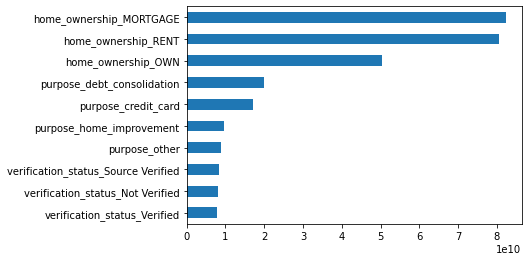

In [50]:
importances = model_linear.named_steps['linearregression'].coef_
features = model_linear.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances, index = features).abs().sort_values()
feat_imp.tail(10).plot(kind='barh')

In [58]:
alphas = np.arange(1, 500, 25)
train_acc_ridge = []
val_acc_ridge = []
for a in alphas:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = a))
    model.fit(X_train, y_train)
    train_acc_ridge.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_ridge.append(mean_absolute_error(y_val, model.predict(X_val)))
    
pd.DataFrame(list(zip(train_acc_ridge, val_acc_ridge)), index = alphas, 
             columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,0.580738,0.629479
26,0.580687,0.629254
51,0.580653,0.629058
76,0.580639,0.628888
101,0.580640,0.628742
126,0.580656,0.628621
151,0.580685,0.628525
176,0.580725,0.628448
201,0.580776,0.628388
226,0.580837,0.628344


In [59]:
alphas = np.arange(1, 20, 1)
train_acc_ridge = []
val_acc_ridge = []
for a in alphas:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = a))
    model.fit(X_train, y_train)
    train_acc_ridge.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_ridge.append(mean_absolute_error(y_val, model.predict(X_val)))
    
pd.DataFrame(list(zip(train_acc_ridge, val_acc_ridge)), index = alphas, 
             columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,0.580738,0.629479
2,0.580736,0.629469
3,0.580733,0.629460
4,0.580731,0.629450
5,0.580729,0.629441
6,0.580727,0.629431
7,0.580724,0.629422
8,0.580722,0.629413
9,0.580720,0.629404
10,0.580718,0.629394


In [60]:
model_ridge = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = 1))

In [61]:
model_ridge.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train,model_ridge.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val,model_ridge.predict(X_val)))
print('Validation R2:', model_ridge.score(X_val,y_val))

Training MAE: 0.5807383064382666
Validation MAE: 0.6294785161440285
Validation R2: 0.9512037889465321


<AxesSubplot:>

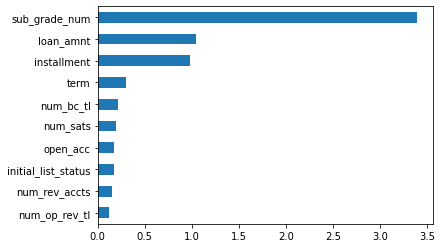

In [62]:
importances = model_ridge.named_steps['ridge'].coef_
features = model_ridge.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances, index = features).abs().sort_values()
feat_imp.tail(10).plot(kind = 'barh')

In [64]:
depths = np.arange(1, 20, 1)
train_acc_dt = []
val_acc_dt = []

for depth in depths:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         DecisionTreeRegressor(random_state = 42,
                                               max_depth = depth))
    model.fit(X_train, y_train)
    train_acc_dt.append(mean_absolute_error(y_train, model.predict(X_train)))
    val_acc_dt.append(mean_absolute_error(y_val, model.predict(X_val)))
pd.DataFrame(list(zip(train_acc_dt, val_acc_dt)), index = depths,
            columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,1.801336,1.953992
2,0.986316,1.054245
3,0.734247,0.742831
4,0.640969,0.603238
5,0.601464,0.581720
6,0.584384,0.603068
7,0.566096,0.604537
8,0.551791,0.604634
9,0.536889,0.608125
10,0.518677,0.610741


In [65]:
model_dt = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        DecisionTreeRegressor(random_state = 42,
                                             max_depth = 5))

In [66]:
model_dt.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train,model_dt.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val,model_dt.predict(X_val)))
print('Validation R2:', model_dt.score(X_val,y_val))

Training MAE: 0.6014635020925977
Validation MAE: 0.5817198288440972
Validation R2: 0.9573789366117911


<AxesSubplot:>

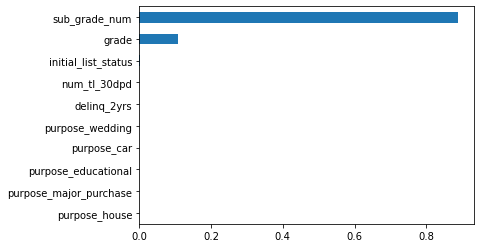

In [67]:
importances = model_dt.named_steps['decisiontreeregressor'].feature_importances_
features = model_dt.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances, index = features).abs().sort_values()
feat_imp.tail(10).plot(kind = 'barh')

In [106]:
model_boost = make_pipeline(OneHotEncoder(use_cat_names = True),
                           StandardScaler(),
                           SimpleImputer(strategy='mean'),
                           XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 12,
                                        n_estimators = 170))

In [107]:
model_boost.fit(X_train, y_train)
print('Training MAE:', mean_absolute_error(y_train,model_boost.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val,model_boost.predict(X_val)))
print('Validation R2:', model_boost.score(X_val,y_val))

Training MAE: 0.025847809563591808
Validation MAE: 0.4624599512543348
Validation R2: 0.9727061496448625


<AxesSubplot:>

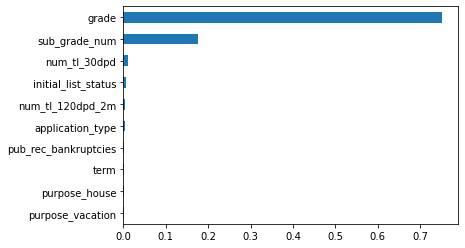

In [108]:
importances = model_boost.named_steps['xgbregressor'].feature_importances_
features = model_boost.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances, index = features).abs().sort_values()
feat_imp.tail(10).plot(kind = 'barh')

<h1>Dropping the 'Grade' and 'Subgrade' columns from the dataset:

In [68]:
data2 = data.drop(columns = ['grade', 'sub_grade_num'])
target = 'int_rate'
y2 = data2[target]
X2 = data2.drop(columns = target)

In [70]:
cutoff = '2017-01-01'
mask = X2.index < cutoff
X2_train, y2_train = X2[mask], y2[mask]
X2_val, y2_val = X2[~mask], y2[~mask]

print(f'The shape of the training data is {X2_train.shape} for X and {y2_train.shape} for y.')
print(f'The shape of the validation data is {X2_val.shape} for X and {y2_val.shape} for y.')

assert len(X2_train) + len(X2_val) == len(X2)

The shape of the training data is (103649, 59) for X and (103649,) for y.
The shape of the validation data is (24685, 59) for X and (24685,) for y.


In [94]:
depths = np.arange(1, 20, 1)
train_acc_dt = []
val_acc_dt = []

for depth in depths:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                         StandardScaler(),
                         SimpleImputer(strategy = 'mean'),
                         DecisionTreeRegressor(random_state = 42,
                                               max_depth = depth))
    model.fit(X2_train, y2_train)
    train_acc_dt.append(mean_absolute_error(y2_train, model.predict(X2_train)))
    val_acc_dt.append(mean_absolute_error(y2_val, model.predict(X2_val)))
pd.DataFrame(list(zip(train_acc_dt, val_acc_dt)), index = depths,
            columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,2.748390,3.051541
2,2.536367,2.827705
3,2.446738,2.729385
4,2.377227,2.700165
5,2.308352,2.693022
6,2.247705,2.627714
7,2.180729,2.579956
8,2.111008,2.533643
9,2.026781,2.492753
10,1.943824,2.451776


In [97]:
model_dt2 = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        DecisionTreeRegressor(random_state = 42,
                                             max_depth = 12))

In [98]:
model_dt2.fit(X2_train, y2_train)
print('Training MAE:', mean_absolute_error(y2_train, model_dt2.predict(X2_train)))
print('Validation MAE:', mean_absolute_error(y2_val, model_dt2.predict(X2_val)))
print('Validation R2:', model_dt2.score(X2_val,y2_val))

Training MAE: 1.7321368471853769
Validation MAE: 2.4109564659798925
Validation R2: 0.35802889555065953


<AxesSubplot:>

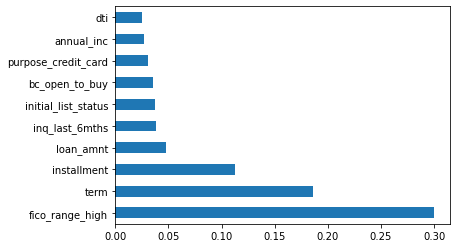

In [136]:
importances = model_dt2.named_steps['decisiontreeregressor'].feature_importances_
features = model_dt2.named_steps['onehotencoder'].get_feature_names()
feat_imp_dt = pd.Series(importances, index = features,
                       name = 'tree').abs().sort_values(ascending=False)
feat_imp_dt.head(10).plot(kind = 'barh')

In [100]:
estimators = np.arange(10, 201, 10)
train_acc_rf = []
val_acc_rf = []

for estimator in estimators:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestRegressor(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = 12,
                                              n_estimators = estimator))
    model.fit(X2_train, y2_train)
    train_acc_rf.append(mean_absolute_error(y2_train, model.predict(X2_train)))
    val_acc_rf.append(mean_absolute_error(y2_train, model.predict(X2_train)))
pd.DataFrame(list(zip(train_acc_rf, val_acc_rf)), index = estimators,
            columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
10,1.629069,1.629069
20,1.606314,1.606314
30,1.594324,1.594324
40,1.593619,1.593619
50,1.593464,1.593464
60,1.591990,1.591990
70,1.593637,1.593637
80,1.592755,1.592755
90,1.591628,1.591628
100,1.592809,1.592809


In [102]:
samples = np.arange(0.05, 1, 0.05)
train_acc_rf = []
val_acc_rf = []

for sample in samples:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestRegressor(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = 12,
                                              n_estimators = 30,
                                              max_samples = sample))
    model.fit(X2_train, y2_train)
    train_acc_rf.append(mean_absolute_error(y2_train, model.predict(X2_train)))
    val_acc_rf.append(mean_absolute_error(y2_train, model.predict(X2_train)))
pd.DataFrame(list(zip(train_acc_rf, val_acc_rf)), index = samples,
            columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
0.05,1.891344,1.891344
0.10,1.822809,1.822809
0.15,1.779799,1.779799
0.20,1.741013,1.741013
0.25,1.712579,1.712579
0.30,1.690993,1.690993
0.35,1.674893,1.674893
0.40,1.657612,1.657612
0.45,1.637803,1.637803
0.50,1.640583,1.640583


In [103]:
model_rf = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestRegressor(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = 12,
                                              n_estimators = 170))

In [104]:
model_rf.fit(X2_train, y2_train)
print('Training MAE:', mean_absolute_error(y2_train, model_rf.predict(X2_train)))
print('Validation MAE:', mean_absolute_error(y2_val, model_rf.predict(X2_val)))
print('Validation R2:', model_rf.score(X2_val,y2_val))

Training MAE: 1.5914313441797772
Validation MAE: 2.1886694736115557
Validation R2: 0.4731072734883345


<AxesSubplot:>

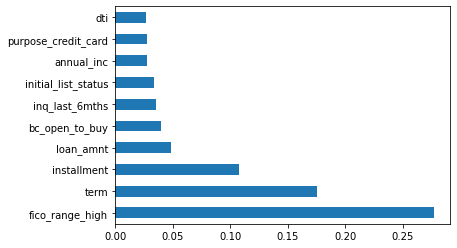

In [137]:
importances = model_rf.named_steps['randomforestregressor'].feature_importances_
features = model_rf.named_steps['onehotencoder'].get_feature_names()
feat_imp_rf = pd.Series(importances, index = features,
                       name = 'forest').abs().sort_values(ascending=False)
feat_imp_rf.head(10).plot(kind = 'barh')

In [111]:
model_boost2 = make_pipeline(OneHotEncoder(use_cat_names = True),
                           StandardScaler(),
                           SimpleImputer(strategy='mean'),
                           XGBRegressor(random_state = 42,
                                        n_jobs = -1,
                                        max_depth = 12,
                                        n_estimators = 170))

In [113]:
model_boost2.fit(X2_train, y2_train)
print('Training MAE:', mean_absolute_error(y2_train,model_boost2.predict(X2_train)))
print('Validation MAE:', mean_absolute_error(y2_val,model_boost2.predict(X2_val)))
print('Validation R2:', model_boost2.score(X2_val,y2_val))

Training MAE: 0.0430568403702173
Validation MAE: 1.0523155378643403
Validation R2: 0.8635311419645664


<AxesSubplot:>

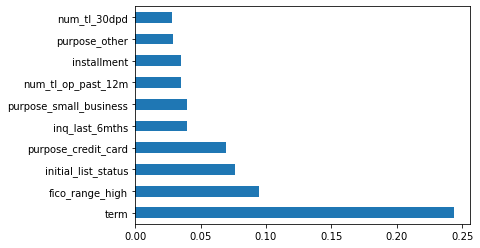

In [138]:
importances = model_boost2.named_steps['xgbregressor'].feature_importances_
features = model_boost2.named_steps['onehotencoder'].get_feature_names()
feat_imp_boost = pd.Series(importances, index = features,
                          name = 'boost').abs().sort_values(ascending=False)
feat_imp_boost.head(10).plot(kind = 'barh')

In [92]:
alphas = np.arange(1, 20, 1)
train_acc_ridge2 = []
val_acc_ridge2 = []
for a in alphas:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = a))
    model.fit(X2_train, y2_train)
    train_acc_ridge2.append(mean_absolute_error(y2_train, model.predict(X2_train)))
    val_acc_ridge2.append(mean_absolute_error(y2_val, model.predict(X2_val)))
    
pd.DataFrame(list(zip(train_acc_ridge2, val_acc_ridge2)), index = alphas, 
             columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,1.799061,2.151131
2,1.799128,2.151232
3,1.799195,2.151334
4,1.799262,2.151435
5,1.799329,2.151537
6,1.799397,2.151640
7,1.799465,2.151743
8,1.799533,2.151845
9,1.799601,2.151949
10,1.799669,2.152052


In [96]:
alphas = np.arange(1, 500, 25)
train_acc_ridge2 = []
val_acc_ridge2 = []
for a in alphas:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = a))
    model.fit(X2_train, y2_train)
    train_acc_ridge2.append(mean_absolute_error(y2_train, model.predict(X2_train)))
    val_acc_ridge2.append(mean_absolute_error(y2_val, model.predict(X2_val)))
    
pd.DataFrame(list(zip(train_acc_ridge2, val_acc_ridge2)), index = alphas, 
             columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,1.799061,2.151131
26,1.800790,2.153732
51,1.802626,2.156412
76,1.804542,2.159138
101,1.806536,2.161874
126,1.808586,2.164642
151,1.810688,2.167479
176,1.812818,2.170322
201,1.814971,2.173177
226,1.817135,2.176011


In [86]:
model_ridge2 = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = 1))

In [87]:
model_ridge2.fit(X2_train, y2_train)
print('Training MAE:', mean_absolute_error(y2_train, model_ridge2.predict(X2_train)))
print('Validation MAE:', mean_absolute_error(y2_val, model_ridge2.predict(X2_val)))
print('Validation R2:', model_ridge2.score(X2_val,y2_val))

Training MAE: 1.7990610848864952
Validation MAE: 2.1511312136724556
Validation R2: 0.5163859740224945


<AxesSubplot:>

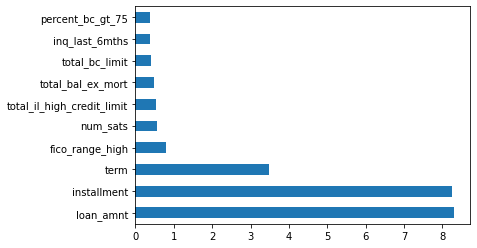

In [139]:
importances = model_ridge2.named_steps['ridge'].coef_
features = model_ridge2.named_steps['onehotencoder'].get_feature_names()
feat_imp_ridge = pd.Series(importances, index = features,
                          name = 'ridge').abs().sort_values(ascending=False)
feat_imp_ridge.head(10).plot(kind = 'barh')

In [85]:
model_linear2 = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            LinearRegression())

In [89]:
model_linear2.fit(X2_train, y2_train)
print('Training MAE:', mean_absolute_error(y2_train, model_linear2.predict(X2_train)))
print('Validation MAE:', mean_absolute_error(y2_val, model_linear2.predict(X2_val)))
print('Validation R2:', model_linear2.score(X2_val,y2_val))

Training MAE: 1.7989928281608871
Validation MAE: 2.1510518991444316
Validation R2: 0.5164019742094981


<AxesSubplot:>

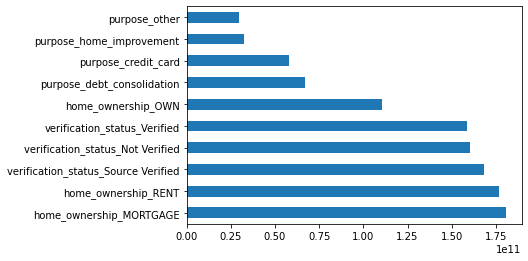

In [140]:
importances = model_linear2.named_steps['linearregression'].coef_
features = model_linear2.named_steps['onehotencoder'].get_feature_names()
feat_imp_linear = pd.Series(importances, index = features,
                           name = 'linear').abs().sort_values(ascending=False)
feat_imp_linear.head(10).plot(kind = 'barh')

In [141]:
for data in [feat_imp_boost, feat_imp_rf, feat_imp_dt, 
          feat_imp_ridge, feat_imp_linear]:
    for i in range(len(data)):
        data[i] = i

In [142]:
pd.concat([feat_imp_boost, feat_imp_ridge, feat_imp_linear, 
          feat_imp_rf, feat_imp_dt], axis = 1)

,boost,ridge,linear,forest,tree
term,0.0,2.0,25.0,1.0,1.0
fico_range_high,1.0,3.0,26.0,0.0,0.0
initial_list_status,2.0,12.0,35.0,6.0,5.0
purpose_credit_card,3.0,14.0,7.0,8.0,7.0
inq_last_6mths,4.0,8.0,31.0,5.0,4.0
purpose_small_business,5.0,23.0,13.0,49.0,48.0
num_tl_op_past_12m,6.0,13.0,36.0,10.0,11.0
installment,7.0,1.0,24.0,2.0,2.0
purpose_other,8.0,16.0,9.0,34.0,33.0
num_tl_30dpd,9.0,65.0,71.0,52.0,64.0
